# Data exploration v2

Objectives:
1. Determine "event fraction distribution," i.e. box plots showing distribution of energy across layer0, layer1, layer2, layer3 for each type of particle
2. Determine if "overflow" accounts for missing energy
3. Find out how sparse everything actually is (with the goal of setting a cutoff for sparse padding etc.)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import linregress
import pandas as pd

In [3]:
data_dir = "/usatlas/atlas01/atlasdisk/users/atlas_wifeng/photon-jet/data/npz"
jet_paths = {
    "pions": "pi0_40-250GeV_100k.npz",
    "photons": "gamma_40-250GeV_100k.npz",
    "scalars": "scalar1_40-250GeV_100k.npz"
}

In [4]:
jets = {}
for particle in jet_paths:
    jets[particle] = dict(np.load(f"{data_dir}/{jet_paths[particle]}"))

In [5]:
keys = list(jets["pions"].keys())
def nth_jet(n, jets):
    jet = {}
    for key in keys:
        jet[key] = jets[key][n]
    return jet

## 1. "Event fraction distribution"

Box plots showing distribution of energy across the layers, for each particle (3 layered bar plots)

In [6]:
# "event fraction distribution"
def energy_frac_dist(jets):
    N = len(jets[keys[0]])
    return [jets[f"layer_{i}"].reshape(N, -1).sum(axis=1) for i in range(4)]

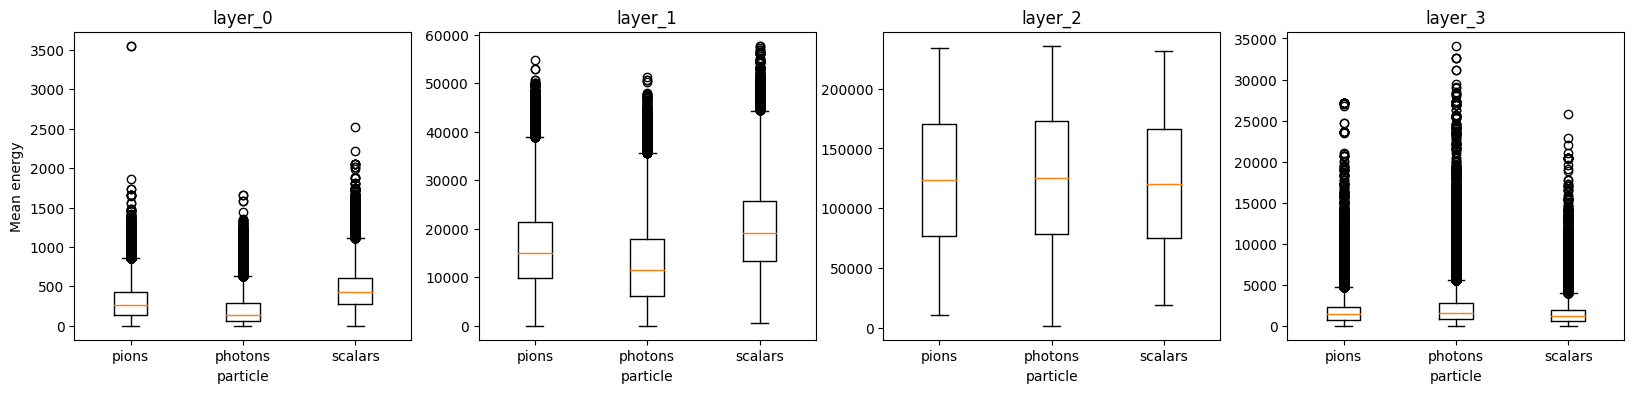

In [7]:
fig, axs = plt.subplots(1, 4, figsize=(20, 4))

axs[0].set_ylabel("Mean energy")

efds = [energy_frac_dist(jets[particle]) for particle in jets.keys()]

import warnings

# There's a UserWarning about something something Fixed something
#   that's just too annoying
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for i, ax in enumerate(axs):
        axs[i].set_title(f"layer_{i}")
        axs[i].set_xlabel("particle")
        axs[i].set_xticklabels(list(jets.keys()))
        axs[i].boxplot([efd[i] for efd in efds])

## 2. Determine if "overflow" accounts for missing energy

In [8]:
pions = jets["pions"]
N = len(pions[keys[0]])

energy = pions["energy"].flatten()
sum_overflow = np.sum(pions["overflow"], axis=1)
sum_layers = np.sum(np.array([np.sum(pions[f"layer_{i}"].reshape(N, -1), axis=1) for i in range(4)]), axis=0)

In [9]:
def analyze(x, y):
    plt.scatter(x, y)
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    print(f"r value: {r_value}")

r value: 0.9986113092650537


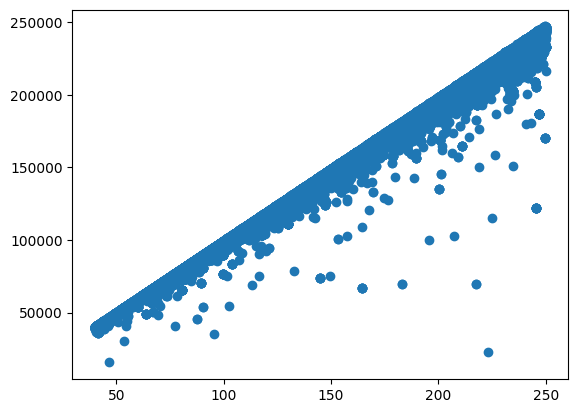

In [10]:
analyze(energy, sum_layers + sum_overflow);

It does not :(

## 3. Determine how sparse jets actually are

In [11]:
# Combine everything in layer_1
def graph_jet(jet):
    fig, axs = plt.subplots(1, 4, figsize=(20, 4))
    for i in range(4):
        axs[i].imshow(
            np.log(jet[f"layer_{i}"].T),
            interpolation="none",
            cmap="viridis",
            extent=[-0.2, 0.2, -0.02, 0.02],
            aspect=10
        )

/tmp/ipykernel_28755/147294354.py:6: RuntimeWarning: divide by zero encountered in log
  np.log(jet[f"layer_{i}"].T),


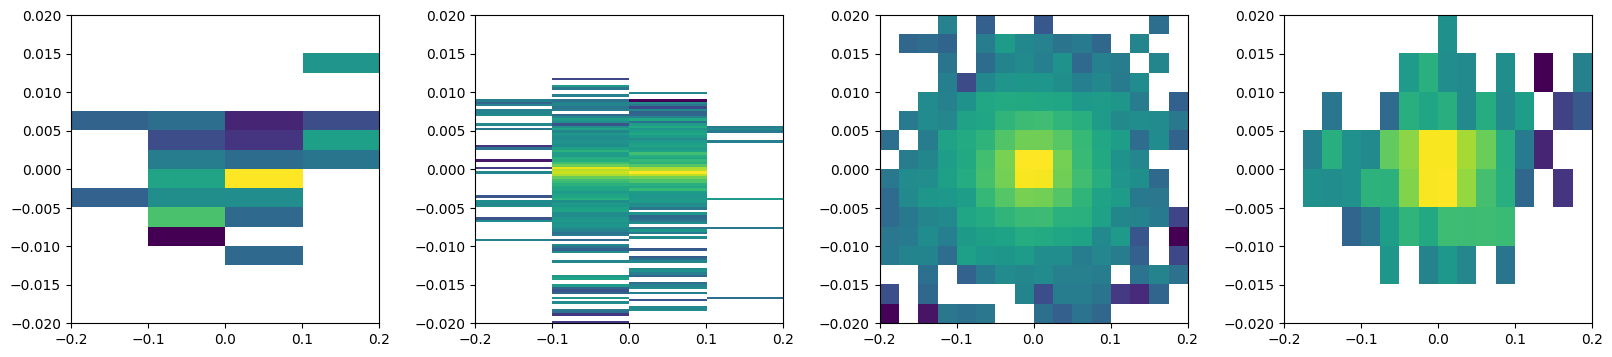

In [12]:
pions = jets["pions"]
graph_jet(nth_jet(0, pions))

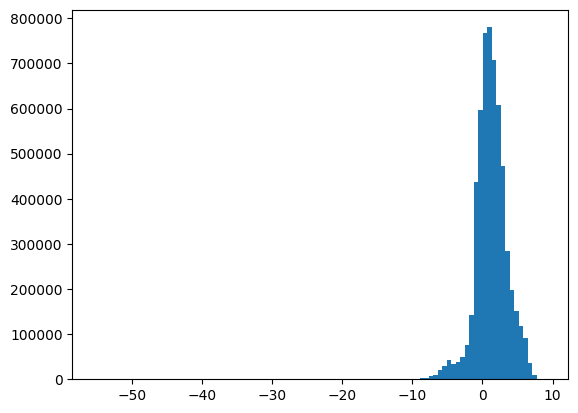

In [24]:
# How low do energies actually get?
cell_energies = pions[f"layer_3"]
plt.hist(np.log(cell_energies[cell_energies > 0]), bins=100);

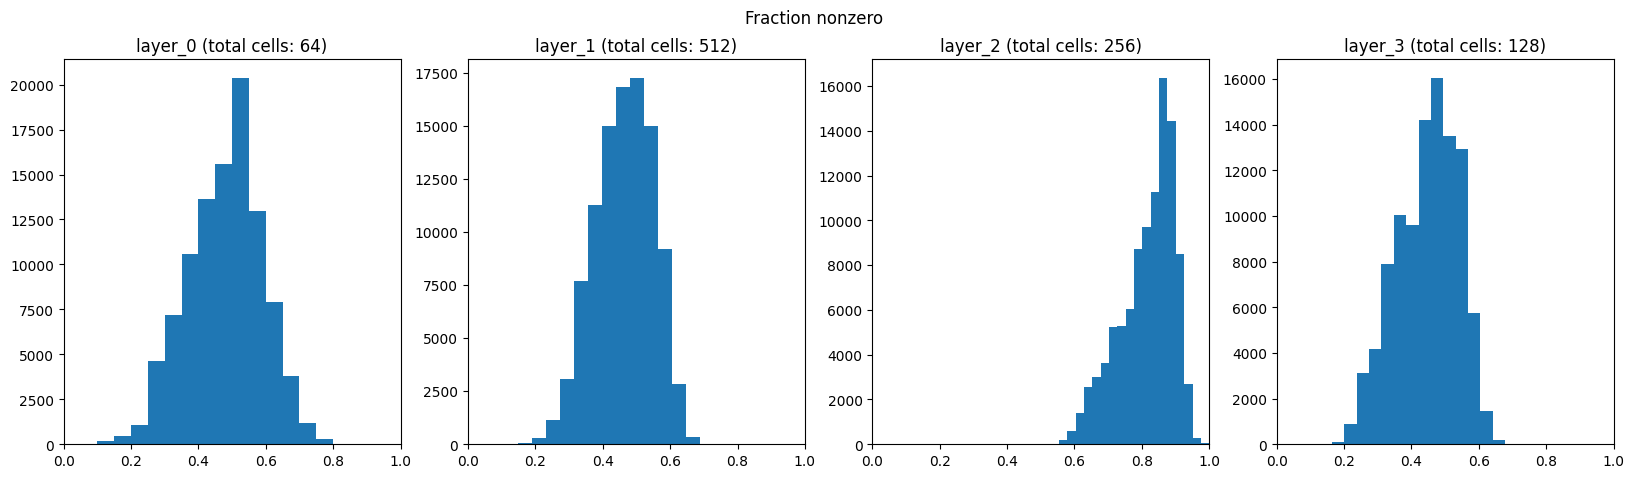

In [31]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    shape = pions[f'layer_{i}'].shape
    total = shape[1] * shape[2]
    
    nonzero = np.sum(pions[f"layer_{i}"] > 1e-5, axis=(1, 2))
    axs[i].hist(nonzero / total, bins=20);
    axs[i].set_title(f"layer_{i} (total cells: {shape[1] * shape[2]})")
    axs[i].set_xlim([0, 1])

plt.suptitle("Fraction nonzero");